In [1]:
import pandas as pd
import os

In [2]:
eventos=pd.read_json("../data/eda/simulation.jsonlines", orient="records",lines=True)
planes=pd.read_json("../data/eda/plans.jsonlines", orient="records",lines=True)


In [3]:
# ¿Cuántos camiones hay?
print("Camiones: ", eventos["truckId"].nunique())
# ¿Cuántas localizaciones hay?
paquetes = pd.concat([pd.DataFrame(x) for x in planes["items"]])
print("Localizaciones: ", paquetes["locationId"].nunique())
# ¿Cuántos viajes hay? Interpretando que un viaje es la ruta de un camión en una simulación
print("Viajes: ", len(eventos.groupby(["truckId", "simulationId"])))
# ¿Cuántas simulaciones hay?
print("Simulaciones: ", eventos["simulationId"].nunique())

Camiones:  19
Localizaciones:  2637
Viajes:  647
Simulaciones:  100


In [4]:
viajes = []
for truck_list in planes["trucks"]:
    for truck in truck_list:
        viajes.append(pd.DataFrame(truck["route"]))
viajes = pd.concat(viajes)
viajes.duration.describe()

count    8346.000000
mean      838.792475
std       816.128037
min         0.000000
25%       308.000000
50%       569.500000
75%      1046.750000
max      5442.000000
Name: duration, dtype: float64

In [5]:
# filtramos los viajes que no tienen duración
viajes[viajes.duration > 0].duration.describe()

count    8336.000000
mean      839.798704
std       816.099847
min        21.000000
25%       308.750000
50%       570.000000
75%      1047.000000
max      5442.000000
Name: duration, dtype: float64

In [6]:
# Ordenamos los eventos por simulación, camión y tiempo
eventos = eventos.sort_values(["simulationId", "truckId", "eventTime"])
# filtramos para quedarnos con los eventos que nos interesan
entregas = eventos[eventos.eventType.isin(["Truck started delivering", "Truck ended delivering"])]
# restamos a cada fila el tiempo del evento anterior y luego nos quedamos solo con los eventos de fin de entrega
entregas = entregas.assign(delta=entregas.eventTime - entregas.eventTime.shift(1)).loc[entregas.eventType == "Truck ended delivering"]
entregas.delta.describe()

count      8669.000000
mean      84265.864575
std       37377.325128
min           0.000000
25%       60600.000000
50%       60630.000000
75%      120600.000000
max      120960.000000
Name: delta, dtype: float64

In [18]:

# filtramos las entregas que no tienen duración
tiempos_entrega = entregas[entregas.delta > 0].delta.describe()
tiempos_entrega

count      8032.000000
mean      90948.802291
std       29999.923831
min       60300.000000
25%       60600.000000
50%      120570.000000
75%      120600.000000
max      120960.000000
Name: delta, dtype: float64

<AxesSubplot:ylabel='Frequency'>

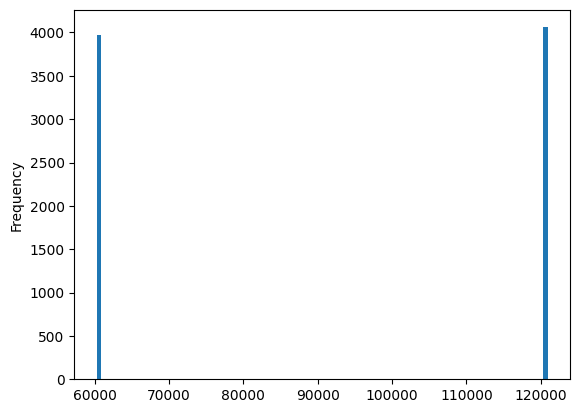

In [8]:
# en una gráfica
entregas[entregas.delta > 0].delta.plot.hist(bins=100)

In [9]:
# Número de paquetes por cada camión. Considerando en cada simulación
camiones = []
for simId in planes.simulationId.unique():
    for truck in planes[planes.simulationId == simId].trucks.values[0]:
        camiones.append(pd.DataFrame(truck["route"]).assign(simulationId=simId, truckId=truck["truck_id"]))
camiones = pd.concat(camiones)
paquetes_camion = camiones.groupby(["simulationId", "truckId"]).size().describe()
paquetes_camion

count    1296.000000
mean        6.439815
std         3.154124
min         2.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        15.000000
dtype: float64

In [10]:
# Número de paquetes por cada simulación
paquetes_simulacion = planes["items"].apply(len).describe()
paquetes_simulacion

count    204.000000
mean      86.294118
std        9.408191
min       62.000000
25%       80.750000
50%       86.000000
75%       93.000000
max      110.000000
Name: items, dtype: float64

Las localizaciones más visitadas, con  9  visitas, son:  ['a9881819c6cd403014ae943b' 'f7f92727eca6495955420e45'
 '855b071bf897e2265abd7096' '110fa557196f4977f47ee8a8']
Las localizaciones con más paquetes recibidos son:
110fa557196f4977f47ee8a8    31
794ef428d858678e69ec18f4    26
544dc8cb8104ca9be64e088e    24
3163705e2e4c79485482b907    24
6e6eb4d6c2908b30c625409c    23
7cf64b3077aaeaf30d2d9a0a    22
f7f92727eca6495955420e45    21
31d46e31a77f056cf15f5e18    21
326ae8dc7810de94ef36cda6    21
3e94f75d0fc870c190c36cd1    20
Name: items, dtype: int64
Los camiones con más paquetes transportados son:
truckId
5534TPH    1595
3321FBL    1541
3953RLD    1272
5030LXK     881
6270NFM     840
0013DYS     561
9593DXM     424
8386WZB     331
6965XLY     329
0781PZL     217
dtype: int64
Número de localizaciones distintas que ha visitado cada camión:
truckId
0013DYS     405
0184WLX       5
0265TYL      43
0781PZL     171
1012GWV       4
1161GJN       7
1316CKM       3
1489WHW       7
1669HSZ      36

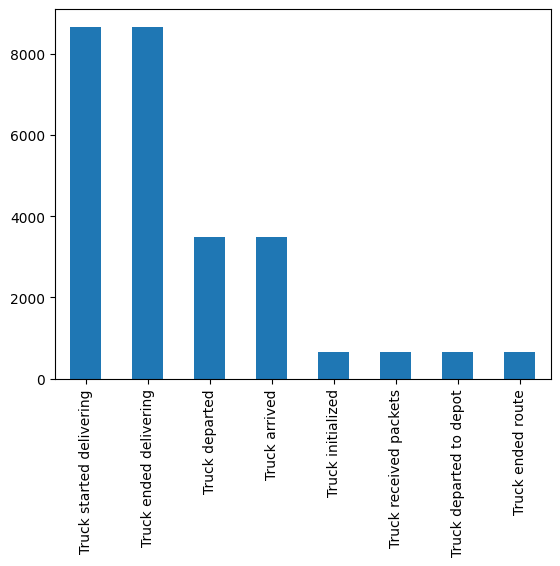

In [11]:
# Localización más visitada. Considero la localización que más veces se ha visitado en diferentes simulaciones
loc_counts = planes["items"].apply(lambda x: set([l["locationId"] for l in x])).explode().value_counts()
print("Las localizaciones más visitadas, con ",loc_counts.values[0], " visitas, son: ", loc_counts.where(loc_counts == loc_counts.values[0]).dropna().index.values)

# Número de paquetes recibidos por cada localización
loc_counts = planes["items"].apply(lambda x: [l["locationId"] for l in x]).explode().value_counts()
print("Las localizaciones con más paquetes recibidos son:")
print(loc_counts.head(10))

# Número de paquetes transportados en total en cada camión
print("Los camiones con más paquetes transportados son:")
print(camiones.groupby(["truckId"]).size().sort_values(ascending=False).head(10))

# Número de localizaciones distintas que ha visitado cada camión
print("Número de localizaciones distintas que ha visitado cada camión:")
print(camiones.groupby(["truckId"])["destination"].nunique())

# Distribución del número de eventos de cada tipo
print("Distribución del número de eventos de cada tipo")
print(eventos.eventType.value_counts().plot.bar())

# Número de paquetes que lleva cada camión en cada viaje (ya calculada en la sección anterior)

In [12]:
eventos = eventos.sort_values(["simulationId", "truckId", "eventTime"])
eventos["prev_event"] = eventos.groupby(["truckId", "simulationId"])["eventType"].shift(1)
eventos["prev_time"] = eventos.groupby(["truckId", "simulationId"])["eventTime"].shift(1)
eventos["delta"] = eventos.eventTime - eventos.prev_time

In [13]:
# La localización que más camiones (distintos) han visitado
loc = camiones.groupby(["truckId"])["destination"].unique().explode().value_counts()
print("La localización que más camiones distintos (",loc.values[0] ,") han visitado es: ", loc.index[0])

# Tiempo de viaje máximo, mínimo y medio. Según los eventos de inicio y fin de viaje
print("Tiempos de viaje: ")
print(eventos[eventos.eventType.isin(["Truck arrived", "Truck ended route"])].delta.describe())

# Tiempo de entrega máximo, mínimo y medio (ya calculado en la primera sección)

# Nº de horas que cada camión ha estado activo
print("Horas que cada camión ha estado activo: ")
print(eventos.groupby(["truckId", "simulationId"]).eventTime.max().reset_index().groupby("truckId")["eventTime"].sum()/3600000)
# Cuántas de viaje
print("De las cuales en viaje: ")
print(eventos[eventos.eventType.isin(["Truck arrived", "Truck ended route"])].groupby("truckId").delta.sum()/3600000)
# Cuántas en total (contando tiempos de entrega)
print("Y entregando paquetes: ")
print(entregas.groupby("truckId").delta.sum()/3600000)


# Diferencia de tiempos entre un evento y el siguiente (de la misma simulación y mismo camión)
print("Diferencia de tiempos entre un evento y el siguiente:")
print(eventos.delta.describe())
# Agregar por tipo de evento “origen” y “destino”
print("Agregando por tipo de evento origen y destino:")
print(eventos.groupby(["prev_event", "eventType"]).delta.describe())

La localización que más camiones distintos ( 20 ) han visitado es:  ce6feed06bc1a9e5aff95f04
Tiempos de viaje: 
count    4.127000e+03
mean     8.886455e+05
std      9.458833e+05
min      0.000000e+00
25%      2.680950e+05
50%      6.051600e+05
75%      1.142160e+06
max      6.598590e+06
Name: delta, dtype: float64
Horas que cada camión ha estado activo: 
truckId
0013DYS     89.882217
0184WLX      1.488900
0265TYL      9.453100
0781PZL     35.891433
1012GWV      1.328825
1161GJN      2.024775
1489WHW      3.558133
1669HSZ     12.557675
2423VRT     24.440883
3321FBL    194.855767
3953RLD    167.681533
5030LXK    162.207192
5534TPH    220.037908
6270NFM    132.996133
6965XLY     83.237717
8327DZH      4.097033
8386WZB     83.632558
8809GPH     13.054583
9593DXM    114.663175
Name: eventTime, dtype: float64
De las cuales en viaje: 
truckId
0013DYS     67.939142
0184WLX      1.287000
0265TYL      7.874367
0781PZL     25.474092
1012GWV      1.227642
1161GJN      0.625025
1489WHW      3.27173

In [14]:
tiempos_plan = camiones.sort_values(["simulationId","truckId"]).assign(duration=lambda x: x["duration"]*1000).groupby(["simulationId","truckId"]).duration.agg(list).reset_index()
tiempos_plan.rename(columns={"duration":"tiempo_plan"}, inplace=True)
tiempos_plan

,simulationId,truckId,tiempo_plan
0,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,3321FBL,"[614000, 397000, 259000, 349000, 384000, 26800..."
1,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,3953RLD,"[4164000, 4064000]"
2,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,5030LXK,"[189000, 1522000, 1655000, 1125000, 2093000, 6..."
3,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,5534TPH,"[630000, 496000, 725000, 680000, 491000, 53400..."
4,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,6270NFM,"[621000, 130000, 294000, 74000, 403000]"
...,...,...,...
1291,fea13535-ade6-4215-96ca-dab5b4ef309b,0013DYS,"[3714000, 3663000]"
1292,fea13535-ade6-4215-96ca-dab5b4ef309b,3953RLD,"[208000, 670000, 260000, 492000, 178000, 79900..."
1293,fea13535-ade6-4215-96ca-dab5b4ef309b,5534TPH,"[589000, 909000, 725000, 455000, 297000, 82900..."
1294,fea13535-ade6-4215-96ca-dab5b4ef309b,6270NFM,"[445000, 223000, 219000, 408000, 1538000, 1591..."


In [15]:
tiempos_sim = eventos[eventos.eventType.isin(["Truck arrived", "Truck ended route"])].sort_values(["simulationId","truckId", "eventTime"]).groupby(["simulationId","truckId"]).delta.agg(list).reset_index()
tiempos_sim.rename(columns={"delta":"tiempo_sim"}, inplace=True)
tiempos_sim

,simulationId,truckId,tiempo_sim
0,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,3321FBL,"[0.0, 482520.0, 311850.0, 418680.0, 458820.0, ..."
1,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,3953RLD,"[0.0, 4524090.0]"
2,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,5030LXK,"[231120.0, 1811130.0, 1950900.0, 0.0, 2418600...."
3,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,5534TPH,"[791640.0, 618480.0, 894330.0, 827790.0, 59145..."
4,007f3d08-14a7-4a93-af9e-f0d9cfbcea94,6270NFM,"[776190.0, 161310.0, 357180.0, 88740.0, 474390.0]"
...,...,...,...
641,fea13535-ade6-4215-96ca-dab5b4ef309b,0013DYS,"[3901230.0, 3846930.0]"
642,fea13535-ade6-4215-96ca-dab5b4ef309b,3953RLD,"[252840.0, 801060.0, 310980.0, 0.0, 210720.0, ..."
643,fea13535-ade6-4215-96ca-dab5b4ef309b,5534TPH,"[723990.0, 1106700.0, 871290.0, 545490.0, 3529..."
644,fea13535-ade6-4215-96ca-dab5b4ef309b,6270NFM,"[576960.0, 287250.0, 278220.0, 516150.0, 19308..."


In [16]:
retrasos = tiempos_sim.merge(tiempos_plan, on=["simulationId","truckId"]).dropna().reset_index(drop=True)

In [17]:
retrasos["retraso"] = retrasos.apply(lambda x: np.array(x.tiempo_sim)-np.array(x.tiempo_plan), axis=1)

NameError: name 'np' is not defined

In [ ]:
valores_retraso = retrasos.explode("retraso").reset_index(drop=True)
valores_retraso.retraso.apply(lambda x: x/1000).describe()

In [ ]:
cargaCamiones = planes.trucks.explode().apply(pd.Series).rename(columns={"items":"truckItems"}).join(planes.drop(columns=["trucks"]), how= "left").reset_index(drop=True)

In [ ]:
from collections import Counter
cargaCamiones=cargaCamiones.assign(paquetesEntregados=cargaCamiones.apply(lambda x: list(Counter([x["items"][int(k)]["locationId"] for k in x["truckItems"]]).values()), axis=1))

In [ ]:
cargaCamiones